### 7.5 卷积神经网络

卷积神经网络和多层感知机这类的深度模型相比，最大的特点就在于卷积层。使用卷积层代替全连接层的主要优势在于可以更好地处理空间信息。在图像分类中，使用全连接层可能会丢失空间信息。比如，在一张图像中，如果绿色部分占据较大面积，而蓝色部分占据较小面积，那么使用全连接层可能会把这两种颜色视为同等重要。而使用卷积层，可以通过卷积核在输入图像上滑动的方式，提取局部信息。这样，卷积层可以根据局部信息更好地学习特征，并保留图像的空间信息。此外，使用卷积层还可以减少网络参数的数量。在卷积层中，一个参数就是卷积核的权值，而在全连接层中，每个节点都需要一个权值。因此，使用卷积层可以大幅减少网络参数的数量，使得网络更加简洁。

举个例子，假设输入是一张 $28\times28$ 的图像，输出是 10 个类别。如果使用全连接层，那么第一层就需要 $28\times28\times10=7840$ 个参数，而使用卷积层，只需要 $5\times5\times10=250$ 个参数。可以看出，使用卷积层的参数数量大大减少，对于较小的数据集来说，使用卷积层可以避免过拟合的问题。

经过前面小节的学习，想必你已经充分理解为什么使用卷积层可以更好地处理空间信息，减少网络参数的数量，使得网络更容易训练。恰恰是这些优势使得，在图像分类等任务中，使用卷积层成为非常常见的做法。本节咱们就来学习最经典的深度卷积神经网络，由Yann LeCun在1998年提出的LeNet。它是为了解决手写数字识别问题而设计的，并且在当时取得了很好的成功。

### 7.5.1 LeNet 模型结构
LeNet的结构如下图所示：

<img src="../images/7-5-1.png" width="90%"></img>

- 输入层：LeNet的输入层接受28x28像素的灰度图像。
- 卷积层1：这一层包含6个卷积核，每个卷积核的大小为5x5，卷积步长为1。该层使用Sigmoid激活函数。
- 池化层1：这一层使用2x2的最大池化窗口，步长为2。这一层的作用是降低图像尺寸，并保留最重要的特征。
- 卷积层2：这一层包含16个卷积核，每个卷积核的大小为5x5，卷积步长为1。该层使用Sigmoid激活函数。
- 池化层2：这一层使用2x2的最大池化窗口，步长为2。这一层的作用与池化层1相同。
- 全连接层：这一层包含120个节点，使用Sigmoid激活函数。
- 全连接层：这一层包含84个节点，使用Sigmoid激活函数。
- 输出层：这一层包含10个节点，对应0~9的十个数字。

**这里为加速收敛将Sigmoid激活函数替换为ReLU函数。**

下面是LeNet模型的代码实现：

In [1]:
import torch
import torch.nn as nn

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 卷积层1：输入1个通道，输出6个通道，卷积核大小为5x5
        self.conv1 = nn.Conv2d(1, 6, 5)
        # 卷积层2：输入6个通道，输出16个通道，卷积核大小为5x5
        self.conv2 = nn.Conv2d(6, 16, 5)
        # 全连接层1：输入16x5x5=400个节点，输出120个节点
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        # 全连接层2：输入120个节点，输出84个节点
        self.fc2 = nn.Linear(120, 84)
        # 输出层：输入84个节点，输出10个节点
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # 使用Sigmoid激活函数，并进行最大池化
        x = torch.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        # 使用Sigmoid激活函数，并进行最大池化
        x = torch.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        # 将多维张量展平为一维张量
        x = x.view(-1, 16 * 4 * 4)
        # 全连接层
        x = torch.relu(self.fc1(x))
        # 全连接层
        x = torch.relu(self.fc2(x))
        # 全连接层
        x = self.fc3(x)
        return x

### 7.5.2. 使用MNIST数据集的模型训练
让我们用MNIST数据集实操一下LeNet的模型训练流程。主要步骤如下：

* 下载MNIST数据集并将其加载到程序中。
* 定义LeNet模型。
* 定义损失函数和优化器。使用交叉熵损失函数和随机梯度下降（SGD）优化器。
* 遍历数据集并使用训练数据训练LeNet模型。在训练过程中，需要计算损失值，并使用优化器更新模型的参数。
* 在训练过程结束后，使用测试数据评估LeNet模型的准确性。

Epoch: 0 Loss: 2.7312533989004866 Acc: 0.2926
Epoch: 2 Loss: 2.0932299511431336 Acc: 0.9009 
Epoch: 4 Loss: 1.669355056561876 Acc: 0.9475  
Epoch: 6 Loss: 1.4936095757677041 Acc: 0.9658 
Epoch: 8 Loss: 1.3853249114034598 Acc: 0.9683 
100%|██████████| 10/10 [02:19<00:00, 13.96s/it]


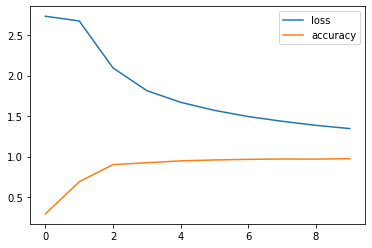

Accuracy: 0.9744


In [2]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import *
import numpy as np
import sys

# 设置随机种子
torch.manual_seed(0)

# 定义模型、优化器、损失函数
model = LeNet()
optimizer = optim.SGD(model.parameters(), lr=0.02)
criterion = nn.CrossEntropyLoss()

# 设置数据变换和数据加载器
transform = transforms.Compose([
    transforms.ToTensor(),  # 将数据转换为张量
    transforms.Normalize((0.5,), (0.5,))  # 对数据进行归一化
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  # 加载训练数据
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)  # 实例化训练数据加载器
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)  # 加载测试数据
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)  # 实例化测试数据加载器

# 设置epoch数并开始训练
num_epochs = 10  # 设置epoch数
loss_history = []  # 创建损失历史记录列表
acc_history = []   # 创建准确率历史记录列表

# tqdm用于显示进度条并评估任务时间开销
for epoch in tqdm(range(num_epochs), file=sys.stdout):
    # 记录损失和预测正确数
    total_loss = 0
    total_correct = 0
    
    # 批量训练
    model.train()
    for inputs, labels in train_loader:

        # 预测、损失函数、反向传播
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 记录训练集loss
        total_loss += loss.item()
    
    # 测试模型，不计算梯度
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:

            # 预测
            outputs = model(inputs)
            # 记录测试集预测正确数
            total_correct += (outputs.argmax(1) == labels).sum().item()
        
    # 记录训练集损失和测试集准确率
    loss_history.append(np.log10(total_loss))  # 将损失加入损失历史记录列表，由于数值有时较大，这里取对数
    acc_history.append(total_correct / len(test_dataset))# 将准确率加入准确率历史记录列表
    
    # 打印中间值
    if epoch % 2 == 0:
        tqdm.write("Epoch: {0} Loss: {1} Acc: {2}".format(epoch, loss_history[-1], acc_history[-1]))

# 使用Matplotlib绘制损失和准确率的曲线图
import matplotlib.pyplot as plt
plt.plot(loss_history, label='loss')
plt.plot(acc_history, label='accuracy')
plt.legend()
plt.show()

# 输出准确率
print("Accuracy:", acc_history[-1])

这段代码使用了MNIST数据集，它包含手写数字的图像和对应的标签。它使用了LeNet模型，并使用了SGD优化器和交叉熵损失函数。每个epoch结束后，它会在测试集上评估模型，并输出测试集上的损失和准确率。如果你想使用其他数据集，你可以替换MNIST数据集，并在train_dataset和test_dataset中使用你想要使用的数据集。你可以在PyTorch的torchvision包中找到许多常见数据集，或者你也可以从外部加载数据。

### 7.5.3. 小结
- 卷积神经网络（CNN）是一种深度学习模型，常用于图像分类和特征提取。
- CNN由卷积层、汇聚层、非线性激活函数和全连接层组成，通过卷积计算、降维和学习非线性关系来提取输入数据的特征。
- 下面是几种提高卷积神经网络性能的方法：
    1. 堆叠更多的卷积层
    2. 使用较小的卷积核
    3. 增加卷积层的通道数
    4. 调整学习率
    5. 调整正则化参数
    6. 调整批量大小
    7. 使用数据增强
- LeNet是最早发布的卷积神经网络之一，虽然发布已经有些时日，但它仍然是一个很好的入门模型。